# Cálculo do valor da promoção de classe

In [1]:
import sys
sys.path.insert(0, r"/Users/hygson/Documents/3 Recursos/Python/Funcoes")
from minhasfuncoes import municipio_das_coordenadas
import radiodifusao as rd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
import pandas as pd
import numpy as np  
import rtree
import folium
import mapclassify
import json

In [2]:
import time
inicio = time.time()

### 01. Dados iniciais
Identificar a latitude, longitude, classe, canal e tipo de mudança de classe da estação na situação proposta.

In [3]:
lat = "24°57'48'' S"         
lon = "53°27'12'' W"
classe_atual = 'B1'
classe_proposta = 'A4'
canal = 210
mudanca = 'gradual'
Tcp = 0  # tempo, em anos, para promoção de classe de forma gradual

In [4]:
# Arquivos:
path_municipios = r"/Users/hygson/Documents/3 Recursos/Dados/Municipios/BR_Municipios_2022.shp"
path_localidades = r"/Users/hygson/Documents/3 Recursos/Dados/Localidades/BR_Localidades_2010_v1.shp"
path_setores_censitarios_cidades = r"/Users/hygson/Documents/3 Recursos/Dados/Setores Censitarios/BR_Setores_2021/areas_urbanas_cidades_2021.shp"
path_populacao = r"/Users/hygson/Documents/3 Recursos/Dados/Populacao/2010/coordenadas-populacao-localidades-2010.csv"
path_populacao_2022 = r"/Users/hygson/Documents/3 Recursos/Dados/Populacao/2022/populacao_municipios_ibge_2022.csv"

### 02. Distância ao contorno protegido
Identificar a distância ao contorno protegido, com base no número e na classe do canal na situação proposta.

In [5]:
dmax_contorno = rd.dmax_cp(classe_proposta, canal)
print(f"Distância ao contorno protegido (canal {canal}, classe {classe_proposta}) = {dmax_contorno} km")

Distância ao contorno protegido (canal 210, classe A4) = 24.0 km


### 03. Shapefiles dos municípios
Criar o geodaframe dos municípios a partir dos shapefiles dos municípios.

In [6]:
gdf_municipios = gpd.read_file(path_municipios)

In [7]:
gdf_municipios.head(3)

CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0  1100015  Alta Floresta D'Oeste       RO  7067.127   
1  1100023              Ariquemes       RO  4426.571   
2  1100031                 Cabixi       RO  1314.352   

                                            geometry  
0  POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...  
1  POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...  
2  POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...

### 04. Município e UF da estação
Identificar o município e a UF da estação na situação proposta.

In [8]:
g = float(lon.split('°')[0])
m = float(lon.split('°')[1].split("'")[0])
s = float(lon.split('°')[1].split("'")[1])
longitude = g + m/60 + s/3600

if lon[-1] == 'W':
    longitude = -longitude

g = float(lat.split('°')[0])
m = float(lat.split('°')[1].split("'")[0])
s = float(lat.split('°')[1].split("'")[1])
latitude = g + m/60 + s/3600

if lat[-1] == 'S':
    latitude = -latitude

# Geodataframe das coordenadas da estação na situação proposta
coordenadas_da_estacao = shapely.geometry.Point(longitude, latitude)
gdf_estacao = gpd.GeoDataFrame(geometry=[coordenadas_da_estacao], crs='EPSG:4674')

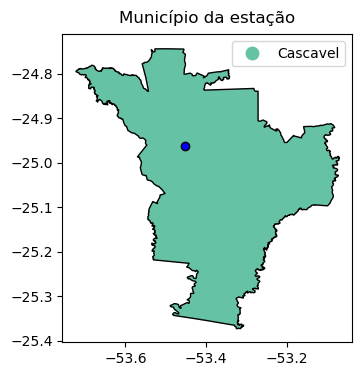

In [9]:
# Polígono do município que contém o ponto da estação
gdf_municipio_estacao = gpd.sjoin(gdf_municipios, gdf_estacao, predicate='contains')
gdf_municipio_estacao = gdf_municipio_estacao.drop('index_right', axis=1)
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.title('Município da estação', fontsize=12, y=1.01)
gdf_municipio_estacao.plot(ax=ax, column='NM_MUN', edgecolor='black', cmap='Set2', legend=True)
gdf_estacao.plot(ax=ax, color='blue', edgecolor='black')
plt.show()

In [10]:
municipio_estacao = gdf_municipio_estacao['NM_MUN'].iloc[0]
uf = gdf_municipio_estacao['SIGLA_UF'].iloc[0]

### 05. Contorno protegido do canal
Criar o geodataframe do contorno protegido do canal (círculo), a partir das coordenadas da estação (centro) e da distância ao contorno protegido (raio).

In [11]:
gdf_contorno_protegido = rd.circulo_gdf(latitude, longitude, dmax_contorno) # contorno protegido

### 06. Coordenadas geográficas das cidades
Criar o geodataframe das coordenadas geográficas das cidades (sedes dos municípios), com base nos shapefiles de localidades de 2010.

In [12]:
gdf_localidades = gpd.read_file(path_localidades)
gdf_cidades = gdf_localidades[gdf_localidades['CD_NIVEL']=='1']
gdf_cidades = gdf_cidades.reset_index(drop=True)

### 07. Distâncias da estação às cidades

In [13]:
gdf_estacao_utm = gdf_estacao.to_crs(epsg=5880)
gdf_cidades_utm = gdf_cidades.to_crs(epsg=5880)
dist_estacao_cidades = gdf_cidades_utm.distance(gdf_estacao_utm.iloc[0].geometry)/1000
gdf_cidades['d_estacao'] = dist_estacao_cidades # distâncias em km

In [14]:
gdf_cidades.head()

ID       CD_GEOCODI    TIPO    CD_GEOCODB        NM_BAIRRO   CD_GEOCODS  \
0   1  110001505000001  URBANO  110001505006          Redondo  11000150500   
1   7  110002305000001  URBANO          None             None  11000230500   
2   8  110003105000001  URBANO          None             None  11000310500   
3  10  110004905000001  URBANO  110004905003  Princesa Isabel  11000490500   
4  19  110005605000001  URBANO          None             None  11000560500   

  NM_SUBDIST CD_GEOCODD             NM_DISTRIT CD_GEOCODM  ... CD_NIVEL  \
0       None  110001505  ALTA FLORESTA D'OESTE    1100015  ...        1   
1       None  110002305              ARIQUEMES    1100023  ...        1   
2       None  110003105                 CABIXI    1100031  ...        1   
3       None  110004905                 CACOAL    1100049  ...        1   
4       None  110005605             CEREJEIRAS    1100056  ...        1   

  CD_CATEGOR NM_CATEGOR             NM_LOCALID       LONG        LAT  \
0         05     CIDADE  ALTA FLORESTA D'OESTE -61.999824 -11.935540   
1         05     CIDADE              ARIQUEMES -63.033269  -9.908463   
2         05     CIDADE                 CABIXI -60.544314 -13.499763   
3         05     CIDADE                 CACOAL -61.442944 -11.433865   
4         05     CIDADE             CEREJEIRAS -60.818426 -13.195033   

          ALT GMRotation                     geometry    d_estacao  
0  337.735719        0.0  POINT (-61.99982 -11.93554)  1703.541009  
1  138.688981        0.0   POINT (-63.03327 -9.90846)  1955.967487  
2  236.063160        0.0  POINT (-60.54431 -13.49976)  1473.046683  
3  177.453547        0.0  POINT (-61.44294 -11.43387)  1721.619330  
4  262.811307        0.0  POINT (-60.81843 -13.19503)  1517.256587  

[5 rows x 24 columns]

### 08. Setores censitários urbanos de cidades
Criar o geodataframe dos setores censitários urbanos (versão 2021) que formam a área urbana do distrito sede, aquele que tem o mesmo nome do município.

In [15]:
gdf_setores_censitarios_cidades = gpd.read_file(path_setores_censitarios_cidades)

In [16]:
gdf_setores_censitarios_cidades.head(2)

CD_SETOR CD_SIT                                        NM_SIT CD_UF  \
0  110001505000001      1  Área Urbana de Alta Densidade de Edificações    11   
1  110001505000002      1  Área Urbana de Alta Densidade de Edificações    11   

      NM_UF SIGLA_UF   CD_MUN                 NM_MUN    CD_DIST  \
0  Rondônia       RO  1100015  Alta Floresta D'Oeste  110001505   
1  Rondônia       RO  1100015  Alta Floresta D'Oeste  110001505   

                 NM_DIST   CD_SUBDIST NM_SUBDIST                    SIT  \
0  Alta Floresta D'Oeste  11000150500       None  área urbana de cidade   
1  Alta Floresta D'Oeste  11000150500       None  área urbana de cidade   

     TIPO                                           geometry  
0  urbano  POLYGON ((-61.99890 -11.93178, -61.99887 -11.9...  
1  urbano  POLYGON ((-61.99996 -11.94202, -62.00570 -11.9...

### 09. Municípios atingidos pelo contorno protegido
Criar o geodataframe dos municípios intersectados pelo contorno protegido (**apenas para visualização**).

In [17]:
# Municípios que fazem interseção com o contorno protegido
gdf_municipios_atingidos_pelo_cp = gpd.sjoin(gdf_municipios, gdf_contorno_protegido, predicate='intersects')
gdf_municipios_atingidos_pelo_cp = gdf_municipios_atingidos_pelo_cp.drop('index_right', axis=1)

### 10. Setores urbanos dos municípios atingidos pelo contorno protegido
Criar o geodataframe dos setores censitários urbanos dos municípios intersectados pelo contorno protegido (**apenas para visualização**).

In [18]:
# Setores censitários urbanos dos municípios que fazem interseção com o contorno protegido
municipios_atingidos_pelo_cp = list(gdf_municipios_atingidos_pelo_cp.CD_MUN)
gdf_setores_urbanos_municipios_atingidos_pelo_cp = gdf_setores_censitarios_cidades[gdf_setores_censitarios_cidades.CD_MUN.isin(municipios_atingidos_pelo_cp)]

In [19]:
# Interseção entre os setores censitários urbanos e os municípios que fazem interseção com o contorno protegido
gdf_setores_urbanos_municipios_atingidos_pelo_cp_2 = gpd.overlay(gdf_setores_censitarios_cidades, gdf_municipios_atingidos_pelo_cp, how='intersection')

/var/folders/_z/54hwkrx94qg86lt6fspcj4yh0000gn/T/ipykernel_38584/890673761.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf_setores_urbanos_municipios_atingidos_pelo_cp_2 = gpd.overlay(gdf_setores_censitarios_cidades, gdf_municipios_atingidos_pelo_cp, how='intersection')


### 11. Cidades cujos municípios são atingidos pelo contorno protegido
Criar o geodataframe das coordenadas geográficas das cidades (pontos) cujos municípios são atingidos pelo contorno protegido (**apenas para visualização**).

In [20]:
# Coordenadas de cidades que estão dentro dos municípios intersectados pelo contorno protegido
gdf_cidades_municipios_atingidos_pelo_cp = gpd.sjoin(gdf_cidades, gdf_municipios_atingidos_pelo_cp.iloc[:,-1:], predicate='within')
gdf_cidades_municipios_atingidos_pelo_cp = gdf_cidades_municipios_atingidos_pelo_cp.drop('index_right', axis=1)

### 12. Áreas urbanas atingidas pelo contorno protegido
Criar o geodataframe dos setores censitários urbanos intersectados pelo contorno protegido, com base no art. 34 da PORTARIA DE CONSOLIDAÇÃO GM/MCOM Nº 9.018, DE 28 DE MARÇO DE 2023:

Art. 34. Nos casos em que o contorno protegido, resultante da alteração das características técnicas pretendida, atingir a zona urbana onde estão localizadas as sedes de mais de um município, o valor a ser pago será calculado tomando por base os preços mínimos de outorga de todos os municípios atendidos. (Origem: PRT GM/MCOM 231/2013, art. 12, caput)

In [21]:
# Setores censitários urbanos que fazem interseção com o contorno protegido
gdf_setores_urbanos_atingidos_pelo_cp = gpd.sjoin(gdf_setores_censitarios_cidades, gdf_contorno_protegido, predicate='intersects')
gdf_setores_urbanos_atingidos_pelo_cp = gdf_setores_urbanos_atingidos_pelo_cp.drop('index_right', axis=1)

In [22]:
# Interseção entre os setores censitários urbanos e o contorno protegido
gdf_intersecao_setores_urbanos_contorno_protegido = gpd.overlay(gdf_setores_censitarios_cidades, gdf_contorno_protegido, how='intersection')

### 13. Municípios com áreas urbanas atingidas pelo contorno protegido
Criar o geodataframe dos municípios cujas áreas urbanas são intersectadas pelo contorno protegido.

In [23]:
codigos_municipios_cobertos = list(gdf_setores_urbanos_atingidos_pelo_cp.CD_MUN.value_counts().index)
gdf_municipios_com_area_urbana_atingida_pelo_cp = gdf_municipios[gdf_municipios.CD_MUN.isin(codigos_municipios_cobertos)]

In [24]:
def municipio_com_codigo(codigo):
    municipio = gdf_municipios[gdf_municipios.CD_MUN == codigo]['NM_MUN'].values[0]
    uf = gdf_municipios[gdf_municipios.CD_MUN == codigo]['SIGLA_UF'].values[0]
    return municipio + '/' + uf

In [25]:
municipios_cobertos = []
for codigo in codigos_municipios_cobertos:
    municipios_cobertos.append(municipio_com_codigo(codigo))

In [26]:
print(f'{len(codigos_municipios_cobertos)} municípios com áreas urbanas atingidas pelo contorno protegido:\n')
print(municipios_cobertos)

3 municípios com áreas urbanas atingidas pelo contorno protegido:

['Cascavel/PR', 'Santa Tereza do Oeste/PR', 'Corbélia/PR']


### 14. Cidades nas áreas urbanas atingidas pelo contorno protegido
Criar o geodataframe das coordenadas geográficas das cidades nos setores censitários urbanos atingidos pelo contorno protegido (**apenas para visualização**).

In [27]:
gdf_cidades_areas_urbanas_atingidas_pelo_cp = gdf_cidades[gdf_cidades.CD_GEOCODM.isin(codigos_municipios_cobertos)]

In [28]:
display(gdf_cidades_areas_urbanas_atingidas_pelo_cp.iloc[:,[13,10,18,19,20,23]])

NM_UF             NM_MUNICIP       LONG        LAT         ALT  \
3979  PARANÁ               CASCAVEL -53.459722 -24.953798  769.528220   
3994  PARANÁ               CORBÉLIA -53.296528 -24.799650  700.236539   
4242  PARANÁ  SANTA TEREZA DO OESTE -53.627236 -25.058722  740.607765   

      d_estacao  
3979   1.237785  
3994  24.079771  
4242  20.488915

### 15. Gráfico
Criar o gráfico mostrando as seguintes informações:

- Municípios atingidos pelo contorno protegido
- Municípios com áreas urbanas atingidas pelo contorno protegido
- Setores urbanos dos municípios atingidos pelo contorno protegido
- Áreas urbanas atingidas pelo contorno protegido
- Cidades cujos municípios são atingidos pelo contorno protegido
- Cidades nas áreas urbanas atingidas pelo contorno protegido
- Estação na situação proposta
- Circunferência do contorno protegido teórico

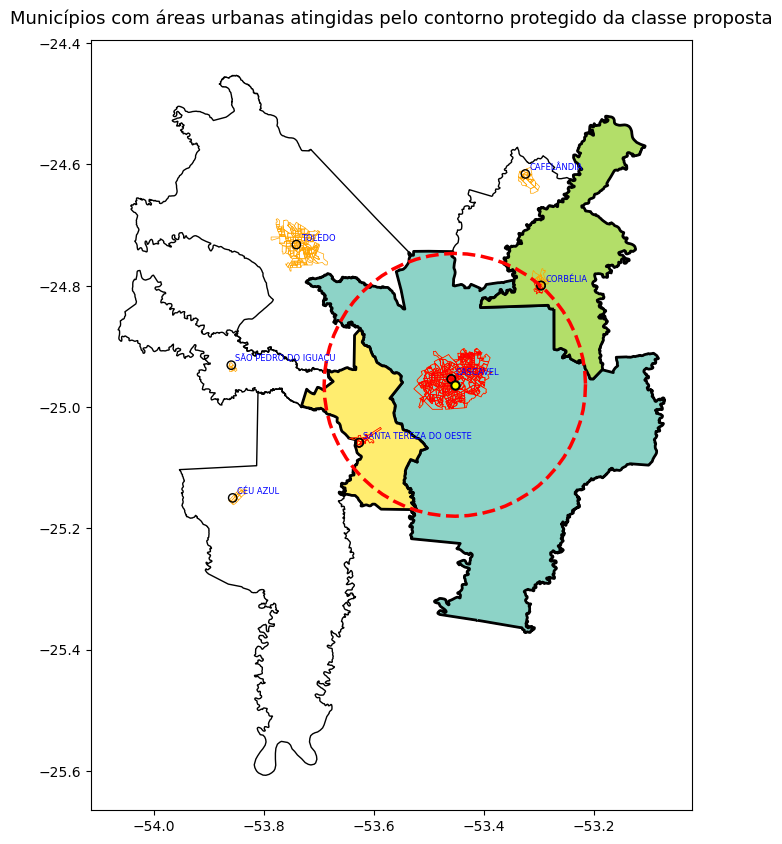

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
#ax.grid(color='grey', linestyle='--', linewidth=0.5)

# Municípios atingidos pelo contorno protegido
gdf_municipios_atingidos_pelo_cp.plot(ax=ax, color='None', edgecolor='black', linewidth=1)

# Municípios com áreas urbanas atingidas pelo contorno protegido
gdf_municipios_com_area_urbana_atingida_pelo_cp.plot(ax=ax, column='NM_MUN', edgecolor='black', cmap='Set3', linewidth=2, legend=False)

# Setores urbanos dos municípios atingidos pelo contorno protegido
gdf_setores_urbanos_municipios_atingidos_pelo_cp_2.plot(ax=ax, color='None', edgecolor='orange', linewidth=0.5)

# Áreas urbanas atingidas pelo contorno protegido
#gdf_setores_urbanos_atingidos_pelo_cp.plot(ax=ax, color='red', edgecolor='red', linewidth=0.5)
gdf_intersecao_setores_urbanos_contorno_protegido.plot(ax=ax, color='None', edgecolor='red', linewidth=0.5)

# Cidades cujos municípios são atingidos pelo contorno protegido
gdf_cidades_municipios_atingidos_pelo_cp.plot(ax=ax, color='None', edgecolor='black', linewidth=1)

# Cidades nas áreas urbanas atingidas pelo contorno protegido
gdf_cidades_areas_urbanas_atingidas_pelo_cp.plot(ax=ax, color='None', edgecolor='black', linewidth=1)

# Estação na situação proposta
gdf_estacao.plot(ax=ax, color='yellow', edgecolor='black', linewidth=1.5)
#ax.annotate("ESTAÇÃO", xy=(gdf_estacao.geometry.x, gdf_estacao.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=6, color='black')

# Circunferência do contorno protegido teórico
gdf_contorno_protegido.plot(ax = ax, color='none', edgecolor='red', linewidth=2.5, linestyle='dashed')

for x, y, label in zip(gdf_cidades_municipios_atingidos_pelo_cp.geometry.x, gdf_cidades_municipios_atingidos_pelo_cp.geometry.y, 
                       gdf_cidades_municipios_atingidos_pelo_cp.NM_MUNICIP):
                       ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=6, color='blue')
        
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0., 0., 1.3, 1.01))
plt.title('Municípios com áreas urbanas atingidas pelo contorno protegido da classe proposta', fontsize=13, y=1.01)
plt.savefig("/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/municipios_com_areas_urbanas_cidades_atingidas_pelo_contorno_protegido.png", format="png", dpi=1200)
plt.savefig("/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/municipios_com_areas_urbanas_cidades_atingidas_pelo_contorno_protegido.pdf", format="pdf", dpi=1200)
plt.show()

In [30]:
m = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.Marker([latitude, longitude], popup="<i>Estação de FM</i>", tooltip="Estação de FM").add_to(m)
folium.Circle(radius = dmax_contorno*1000, location=[latitude, longitude], popup="Contorno Protegido", color="red", weight = 3, fill=False).add_to(m)
folium.GeoJson(gdf_municipios_atingidos_pelo_cp, 
               name="municipios_atingidos_pelo_cp", 
               tooltip=folium.GeoJsonTooltip(fields=['NM_MUN']), 
               style_function = lambda feature: {'fillColor': "None",
                                                 'weight': 1,
                                                 'color': "blue",
                                                 'fillOpacity': 0.8}).add_to(m)
m.add_child(folium.LatLngPopup())

gdf_municipios_com_area_urbana_atingida_pelo_cp.explore(
        m = m,
        column = "NM_MUN",
        cmap = 'Set1',
        style_kwds = {"color": "blue", 'weight': 2},
        tooltip = "NM_MUN",
        tooltip_kwds = dict(labels=False),
        name = "Municípios atingidos pelo contorno protegido"
)

gdf_setores_urbanos_municipios_atingidos_pelo_cp_2.explore(
        m = m,
        style_kwds = {"color": "orange", "fillColor": "None", "weight": 0.5},
        name = "Municípios atingidos pelo contorno protegido"
)

gdf_intersecao_setores_urbanos_contorno_protegido.explore(
        m = m,
        style_kwds = {"color": "red", "fillColor": "None", "weight": 0.5},
        name = "Municípios atingidos pelo contorno protegido"
)

m.save("index.hmtl")

m

### 16. Cálculo do valor da promoção de classe (art. 34 da Portaria GM/MCom nº 9.018/2023)

- Determinar o grupo de enquadramento na situação proposta
- Determinar o valor de referência para promoção de classe
- Determinar a população dos municípios com setores censitários de cidades atingidos pelo contorno protegido
- Calcular o valor a ser pago pela promoção de classe no município

In [31]:
# Determinação do grupo de enquadramento na situação proposta (A para B ou B para C)
def grupo_enquadramento(classe):
    if classe in ['A1','A2','A3','A4','A','B']:
        return 'B'
    elif classe in ['E1','E2','E3','E','A']:
        return 'C'

In [32]:
enquadramento_atual = grupo_enquadramento(classe_atual)
enquadramento_proposto = grupo_enquadramento(classe_proposta)

In [33]:
# Determinação do valor de referência - Anexo XXVIII da Portaria GM/MCom nº 9018/2023
def determina_valor_referencia(uf, enquadramento):    
    if enquadramento == 'B':
        if uf == 'SC':
            return ['Florianópolis', 363499.72]
        elif uf == 'BA':
            return ['Salvador', 169291.50]
        elif uf == 'AM':
            return ['Manaus', 78099.69]
        elif uf == 'PA':
            return ['Belém', 85097.28]
        elif uf == 'SP':
            return ['Região Metropolitana de São Paulo', 2376643.72]
        elif uf == 'CE':
            return ['Fortaleza', 166419.21]
        elif uf == 'GO':
            return ['GOIÂNIA', 235323.01]
        elif uf == 'SE':
            return ['ARACAJÚ', 235323.01]
        elif uf == 'MG':
            return ['BELO HORIZONTE', 53718.66]
        elif uf == 'PB':
            return ['JOÃO PESSOA', 144582.39]        
        elif uf == 'MS':
            return ['CAMPO GRANDE', 215788.29]    
        elif uf == 'DF':
            return ['BRASÍLIA', 307127.24]
        elif uf == 'RO':
            return ['PORTO VELHO', 45590.69]
        elif uf == 'RJ':
            return ['RIO DE JANEIRO', 701663.27]
        elif uf == 'PR':
            return ['Curitiba', 469494.06]       
        elif uf == 'AL':
            return ['MACEIÓ', 144040.28]        
        elif uf == 'PI':
            return ['TERESINA', 144681.50]   
        elif uf == 'RS':
            return ['PORTO ALEGRE', 425475.87]  

    if enquadramento == 'C':
        if uf == 'SC':  
            return ['FLORIANÓPOLIS', 852817.55]
        elif uf == 'BA':
            return ['SALVADOR', 397584.59]
        elif uf == 'AM':
            return ['MANAUS', 183187.51]
        elif uf == 'PA':
            return ['BELÉM', 199600.76]
        elif uf == 'SP':
            return ['REGIÃO METROPOLITANA DE SÃO PAULO', 5574558.80]
        elif uf == 'CE':
            return ['FORTALEZA', 391262.94]
        elif uf == 'GO':
            return ['GOIÂNIA', 551639.11]
        elif uf == 'MG':
            return ['BELO HORIZONTE', 125672.29]
        elif uf == 'PB':
            return ['JOÃO PESSOA', 338855.67]  
        elif uf == 'MS':
            return ['CAMPO GRANDE', 505001.04] 
        elif uf == 'DF':
            return ['BRASÍLIA', 720385.32]
        elif uf == 'RO':
            return ['PORTO VELHO', 105637.44]
        elif uf == 'RJ':
            return ['RIO DE JANEIRO', 1629200.59]
        elif uf == 'PR':
            return ['Curitiba', 1098420.32]
        elif uf == 'AL':
            return ['MACEIÓ', 337505.73]  
        elif uf == 'PI':
            return ['TERESINA', 339511.65]  
        elif uf == 'RS':
            return ['PORTO ALEGRE', 995714.32]  
      
municipio_referencia = determina_valor_referencia(uf, enquadramento_proposto)[0]
valor_referencia = determina_valor_referencia(uf, enquadramento_proposto)[1]

In [34]:
# População de cada município com setor urbano atingido pelo contorno protegido
df_populacao = pd.read_csv(path_populacao)
df_populacao['CD_GEOCODM']= df_populacao['CD_GEOCODM'].apply(str)
# Criando a coluna geometry a partir das coordenadas das cidades
geometry = gpd.points_from_xy(df_populacao['LONG'],df_populacao['LAT']) 
# Transformando dataframe em geodataframe
gdf_populacao = gpd.GeoDataFrame(df_populacao, crs='EPSG:4674', geometry = geometry)

In [35]:
# População dos municípios com setores censitários de cidades atingidos pelo contorno protegido
cod_municipios_cobertos = list(gdf_municipios_com_area_urbana_atingida_pelo_cp['CD_MUN'])
gdf_municipios_cobertos = gdf_populacao[gdf_populacao['CD_GEOCODM'].isin(cod_municipios_cobertos)]
gdf_municipios_cobertos = gdf_municipios_cobertos.reset_index(drop=True)

In [36]:
df_populacao_2022 = pd.read_csv(path_populacao_2022, dtype = {"CD_GEOCODM": str}, usecols = ['UF', 'CD_GEOCODM', 'NOME DO MUNICÍPIO',
       'POPULAÇÃO'])
df_municipios_cobertos = df_populacao_2022[df_populacao_2022['CD_GEOCODM'].isin(cod_municipios_cobertos)]
df_municipios_cobertos = df_municipios_cobertos.reset_index(drop=True)

In [37]:
df_municipios_cobertos

UF CD_GEOCODM      NOME DO MUNICÍPIO  POPULAÇÃO
0  PR    4104808               Cascavel     348051
1  PR    4106308               Corbélia      17470
2  PR    4124020  Santa Tereza do Oeste      13174

#### Valor a ser pago pela promoção de classe no município

In [38]:
pop_municipios_cobertos = df_municipios_cobertos.POPULAÇÃO.sum()

In [39]:
filtro = (df_populacao_2022["NOME DO MUNICÍPIO"] == municipio_referencia) & (df_populacao_2022["UF"] == uf)

if uf == 'SP':
    pop_municipio_referencia = int(19683975)
else:
    pop_municipio_referencia = int(df_populacao_2022[filtro]['POPULAÇÃO'])

Vpc = valor_referencia * pop_municipios_cobertos / pop_municipio_referencia

if mudanca == 'gradual':
    Vpc = round(Vpc,2)
    
elif mudanca == 'não gradual':
    Vab, Vbc = 0, 0
    if enquadramento_proposto == 'B':
        Vab = Vpc
    if enquadramento_proposto == 'C':
        Vbc = Vpc
    Vpc = (Vab + Vbc) * (1 + Tcp/10)
    Vpc = round(Vpc,2)

In [40]:
print(f"Classe proposta do canal: {classe_proposta}\n")
print(f"Distância ao contorno protegido: {dmax_contorno} km\n")
print(f"Município e UF da estação: {municipio_estacao}/{uf}\n")
print(f"Grupo de enquadramento proposto: {enquadramento_proposto}\n")

print(f'{len(municipios_cobertos)} municípios com área urbana atingida pelo CP da classe: \n')

municipios_cob = ""

for i in range(len(municipios_cobertos)):
    municipios_cob = municipios_cob + municipios_cobertos[i] + ", " 
    
print(f"{municipios_cob[:-2]}\n")

for municipio in municipios_cobertos:
    print(municipio)
    
print(f'\nPopulação dos municípios cobertos: {pop_municipios_cobertos}\n')
print(f"Município de referência: {municipio_referencia}/{uf}\n")
print(f"Valor de referência: {valor_referencia}\n")
print(f'População do município de referência: {pop_municipio_referencia}\n')
print(f'Valor de promoção de classe (Vpc): {round(Vpc,2)}')

Classe proposta do canal: A4

Distância ao contorno protegido: 24.0 km

Município e UF da estação: Cascavel/PR

Grupo de enquadramento proposto: B

3 municípios com área urbana atingida pelo CP da classe: 

Cascavel/PR, Santa Tereza do Oeste/PR, Corbélia/PR

Cascavel/PR
Santa Tereza do Oeste/PR
Corbélia/PR

População dos municípios cobertos: 378695

Município de referência: Curitiba/PR

Valor de referência: 469494.06

População do município de referência: 1773718

Valor de promoção de classe (Vpc): 100238.62


### Exportação de shapefiles

- Municípios atingidos pelo contorno protegido
- Coordenadas geográficas das cidades cujos municípios são atingidos pelo contorno protegido
- Setores urbanos de cidades atingidos pelo contorno protegido
- Municípios com os setores urbanos de cidades atingidos pelo contorno protegido
- Coordenadas geográficas de cidades nos setores censitários urbanos atingidos pelo contorno protegido
- Circunferência do contorno protegido teórico
- Estação na situação proposta

In [41]:
gdf_municipios_atingidos_pelo_cp.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/municipios_atingidos_pelo_contorno_protegido.shp")
gdf_municipios_com_area_urbana_atingida_pelo_cp.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/municipios_com_area_urbana_atingida_pelo_cp.shp")
gdf_setores_urbanos_municipios_atingidos_pelo_cp_2.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/setores_urbanos_municipios_atingidos_pelo_cp.shp")
gdf_intersecao_setores_urbanos_contorno_protegido.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/intersecao_setores_urbanos_contorno_protegido.shp")
gdf_cidades_municipios_atingidos_pelo_cp.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/cidades_municipios_atingidos_pelo_cp.shp")
gdf_cidades_areas_urbanas_atingidas_pelo_cp.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/cidades_areas_urbanas_atingidas_pelo_cp.shp")
gdf_estacao.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/coordenadas_da_estacao.shp")
gdf_contorno_protegido.to_file(r"/Users/hygson/Documents/3 Recursos/Python/Radiodifusao/Promocao de classe/Resultados/contorno_protegido.shp")

## Referências

**Principais EPSG** (European Petroleum Survey Group)

Coleção de definições de sistemas de referência de coordenadas e transformações de coordenadas.

- EPSG:4674 --> SIRGAS 2000 --> Unit: degree
- EPSG:5880 --> SIRGAS 2000 / Brazil Polyconic --> Unit: metre
- EPSG:4326 --> WGS 84 used in GPS --> Unit: degree
- EPSG:32629 --> WGS 84 / UTM zone 29N --> Unit: metre
 -EPSG:3857 --> WGS 84 / Pseudo-Mercator --> Unit: metre

**Municípios** 

Os municípios constituem as unidades autônomas de menor hierarquia dentro  da  organização  político-administrativa  do  Brasil.  Sua  criação, incorporação,  fusão  ou  desmembramento  dependem  de  leis  estaduais,  que devem  observar  o  período  determinado  por  lei  complementar  federal  e  a necessidade  de  consulta  prévia,  mediante  plebiscito,  às  populações envolvidas,  após  divulgação  dos  estudos  de  viabilidade  municipal, apresentados e publicados na forma da lei. Os municípios são regidos por 
leis  orgânicas,  observados  os  princípios  estabelecidos  na  Constituição Federal  e  na  constituição  do  estado  onde  se  situam,  e  podem  criar, organizar e suprimir distritos. 

**Cidades**

Cidade é a localidade  onde  está  sediada  a  Prefeitura  Municipal. É constituída pela área urbana do distrito sede e delimitada pelo perímetro urbano (setores tipos 1 e 2) estabelecido por lei municipal. 

Total: 5565 cidades 

Representação espacial: centróide do polígono que representa o setor 0001 do distrito sede de cada município. A exceção desta regra, é o município de São Paulo, cujo centróide do setor considerado foi o que representa o setor 0001 do distrito de Água Rasa (distrito 01).

### Principais operações espaciais no Geopandas entre polígonos de shapefiles e geodataframe

**Identificar (filtrar) pontos que estão dentro de polígonos específicos**

gdf_pontos_dentro_de_poligonos_especificos = gpd.sjoin(gdf_pontos, gdf_poligonos_especificos, predicate='within')

gdf_pontos_dentro_de_poligonos_especificos = gdf_pontos_dentro_de_poligonos_especificos.drop('index_right', axis=1)

**Identificar polígonos que fazem interseção com um polígono específico**

gdf_poligonos_intersectados_por_poligono_especifico = gpd.sjoin(gdf_poligonos, gdf_poligono_especifico, predicate='intersects')

gdf_poligonos_intersectados_por_poligono_especifico = gdf_poligonos_intersectados_por_poligono_especifico.drop('index_right', axis=1)

**Identificar polígonos que contêm pontos ou polígonos específicos**

gdf_poligonos_com_pontos_especificos = gpd.sjoin(gdf_poligonos, gdf_pontos_especificos, predicate='contains')

gdf_poligonos_com_pontos_especificos = gdf_poligonos_com_pontos_especificos.drop(['index_right','ID1'], axis=1)

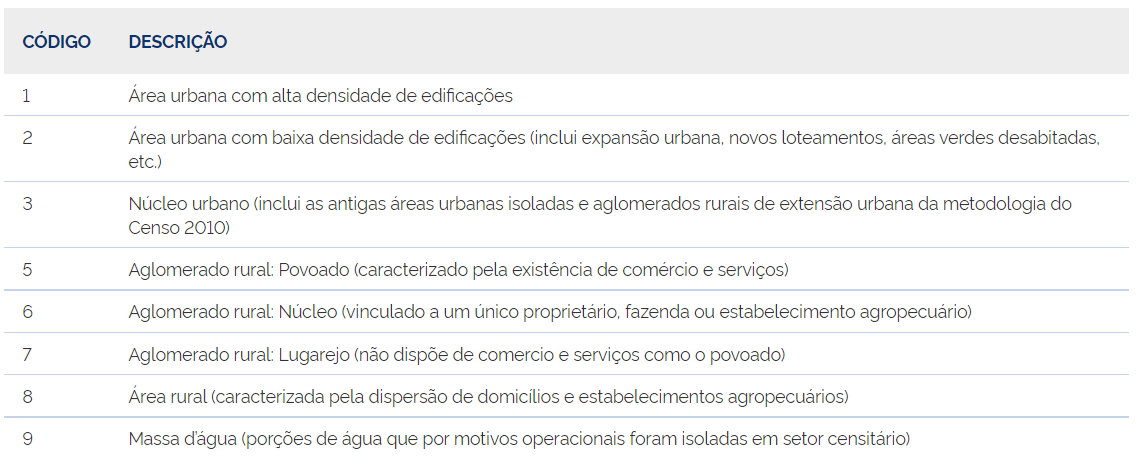

In [42]:
def azimute(lat1, lon1, lat2, lon2):
    
    from math import radians, sin, cos, atan2, sqrt, degrees
    
     # Calcula o azimute entre duas coordenadas, em graus
               
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    difLong = lon2-lon1
    x = sin(difLong) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1) * cos(lat2) * cos(difLong))
    
    azimute = atan2(x, y)     
    azimute = degrees(azimute)
    azimute = (azimute + 360) % 360
    
    return azimute

# CP: 67.5 km

## Situação em que há limitação de irradiação

Passo 1: Calcular a HNMT da estação na situação proposta, na direção do azimute das coordenadas do município (Nioaque/MS) em análise (20° 59' 44.20" S e 55° 13' 54.80" W), através da ferramenta do Mosaico pelo link http://sistemas.anatel.gov.br/se/public/view/b/hnmt.php 

Passo 2: Através do link http://sistemas.anatel.gov.br/se/rf_calculators.php, calcular qual seria a ERP máxima da estação (1.000 kW), dados o canal (227), a HNMT calculada no passo 1 (135 m), a intensidade de campo (66 uV/m) e a distância máxima ao CP da classe pretendida (67,5 km).

Passo 3: Dada a limitação em dB, por exemplo, 6 dB, calcular a ERP equivalente (500 kW)

Passo 4: Através do link http://sistemas.anatel.gov.br/se/rf_calculators.php, com a ERP equivalente calculada no passo 3, calcular a distância máxima ao CP da classe pretendida (53,979 km)

Passo 5: Verificar se a área urbana do município em análise é intersectada pelo círculo centrado na estação transmissora e com raio igual à distância calculada no passo 4.

In [43]:
fim = time.time()
duracao = fim - inicio
print(f"Tempo de execução = {duracao:.1f} segundos")

Tempo de execução = 32.0 segundos


In [44]:
Vab = valor_referencia
Vbc = 0
Pref = 1332570
Ptot = 32627 + 11950 + 7839 + 6654 + 2660 + 2692 + 3119 + 4836 + 6787 + 7650 + 3779 + 2959 + 1933 + 2090 + 2146
Ptot

99721

In [45]:
print(Vab)
print(Ptot)

469494.06
99721


In [46]:
Vpc = (Ptot/Pref) * (Vab + Vbc) * (1 + Tcp/10)
Vpc = round(Vpc,2)
print(Vpc)

35133.93
